In [1]:
# training error and generalization error
# polynomial regression to explore the conception of over fitting and error
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# construction of a dataset
# polynomial is y=5+ 1.2x- 3.4x^2/2!+ 5.6x^3/3!+ noise
max_degree = 20  # max degree of a polynomial
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  # coefficients of the polynomial

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n) = (n-1)!

# dimension of the labels: (n_train+n_test, )
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32)
                                           for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2,:], labels[:2]

(tensor([[-0.2910],
         [-0.9001]]),
 tensor([[ 1.0000e+00, -2.9099e-01,  4.2339e-02, -4.1068e-03,  2.9876e-04,
          -1.7388e-05,  8.4329e-07, -3.5056e-08,  1.2751e-09, -4.1229e-11,
           1.1997e-12, -3.1738e-14,  7.6962e-16, -1.7227e-17,  3.5808e-19,
          -6.9466e-21,  1.2634e-22, -2.1626e-24,  3.4961e-26, -5.3544e-28],
         [ 1.0000e+00, -9.0013e-01,  4.0512e-01, -1.2155e-01,  2.7353e-02,
          -4.9243e-03,  7.3874e-04, -9.4995e-05,  1.0688e-05, -1.0690e-06,
           9.6223e-08, -7.8739e-09,  5.9063e-10, -4.0896e-11,  2.6294e-12,
          -1.5778e-13,  8.8767e-15, -4.7001e-16,  2.3504e-17, -1.1135e-18]]),
 tensor([4.3514, 1.8719]))

In [5]:
def evaluate_loss(net, data_iter, loss):
    """evaluate the loss of the model in the dataset"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # no bias as it has been set in the poly
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs],
                            ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                                   evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.007243   1.2422855 -3.4097729  5.5359726]]


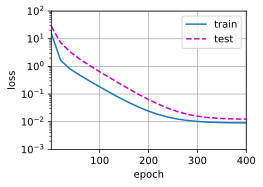

In [7]:
# 3 degree poly fit (normal)
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.7735486 3.11431  ]]


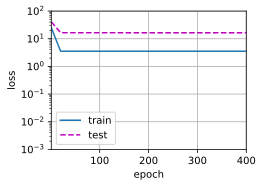

In [8]:
# 2 degree poly fit (under fit)
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 5.0010915   1.2930013  -3.3559203   5.174224   -0.2697675   1.3418396
   0.04484957  0.02913693  0.02453466  0.03655099 -0.12178373 -0.18517351
   0.0608598   0.14155087  0.18169585 -0.14111091  0.18703362 -0.14836837
  -0.20790355 -0.13143608]]


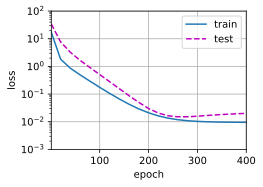

In [9]:
# over fit
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])